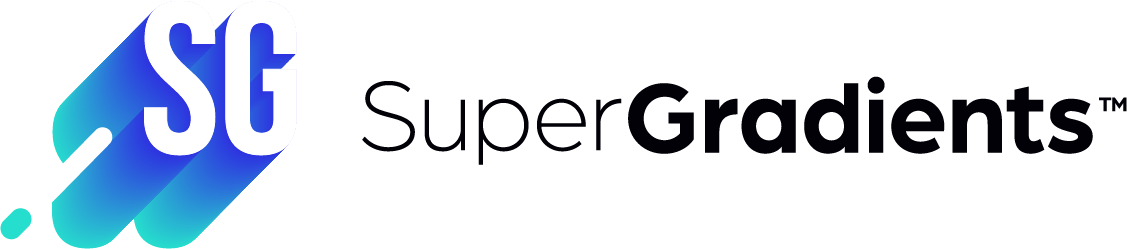

# SuperGradients Transfer Learning Semantic Segmentation

In the following tutorial, we will demonstrate how to use one of SuperGradients pre-trained models and a custom dataset to improve the model's accuracy using transfer learning for semantic segmentation.

Transfer Learning from a pre-trained checkpoint on your own dataset could prove to be very effective instead of deploying the pre-trained model directly on your data or training a model from scratch. For more information on Transfer Learning, please visit: https://cs231n.github.io/transfer-learning/

In the following example, transfer learning will be used from a Cityscapes PPLiteSeg model to a subset of the Supervisely person segmentation dataset .

For more details about the FILTERED dataset we wil use see: https://github.com/PaddlePaddle/PaddleSeg/tree/release/2.3/contrib/PP-HumanSeg

An example real-world use-case of the afformentioned scenario could be background removal in real time for video confrences.[link text](https://)

The notebook is divided into 7 sections:
1. Experiment setup
2. Dataset definition
3. Architecture definition
4. Training setup
5. Training and Evaluation
6. Predict
7. Convert to ONNX\TensorRT

#Install SG

The cell below will install **super_gradients** which will automatically get all its dependencies.

In [1]:
! pip install -qq super-gradients==3.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 59.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 4.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to bu

# 1. Experiment setup
We will initialize our **trainer** which will be in charge of everything, like training, evaluation, saving checkpoints, plotting etc.

The **experiment name** argument is important as every checkpoints, logs and tensorboards to be saved in a directory with the same name. This directory will be created as a sub-directory of **ckpt_root_dir** as follow:

```
ckpt_root_dir
|─── experiment_name_1
│       ckpt_best.pth                     # Model checkpoint on best epoch
│       ckpt_latest.pth                   # Model checkpoint on last epoch
│       average_model.pth                 # Model checkpoint averaged over epochs
│       events.out.tfevents.1659878383... # Tensorflow artifacts of a specific run
│       log_Aug07_11_52_48.txt            # Trainer logs of a specific run
└─── experiment_name_2
        ...
```
In this notebook multi-gpu training is set as `OFF`, for Distributed training multi_gpu can be set as
 `MultiGPUMode.DISTRIBUTED_DATA_PARALLEL` or `MultiGPUMode.DATA_PARALLEL`.

Let's define **ckpt_root_dir** inside the Colab, later we can use it to start TensorBoard and monitor the run.

In [2]:
from super_gradients import Trainer

CHECKPOINT_DIR = './notebook_ckpts/'
trainer = Trainer(experiment_name="segmentation_transfer_learning", ckpt_root_dir=CHECKPOINT_DIR)

[2023-11-13 12:17:11] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2023-11-13 12:17:11] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-11-13 12:17:11] INFO - utils.py - NumExpr defaulting to 2 threads.
[2023-11-13 12:17:26] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-11-13 12:17:26] WARNING - export.py - Failed to import pytorch_quantization
[2023-11-13 12:17:26] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-11-13 12:17:26] WARNING - env_sanity_check.py - Failed to verify installed packages: boto3 required but not found
[2023-11-13 12:17:26] WARNING - env_sanity_check.py - Failed to verify installed packages: deprecated required but not found
[2023-11-13 12:17:26] WARNING - env_sanity_check.py - Failed to verify installed packages: coverage required but not found
[2023-11-13 12:17:26] WARNING - env_sanity_check.py - Failed to verify installed packages: sphinx-rtd-theme required but not found
[2023-11-13 12:17:26] WARNING - env_sanity_check.py - Failed to verify i

# 2. Dataset definition



For the sake of this presentation, we'll use **Supervisely** semantic segmentation dataset.

SG trainer is fully compatible with PyTorch data loaders, so you can definitely use your own data for the experiment below if you prefer.

## 2.1 Download data


Feel free to change the download path by editing SUPERVISELY_DATASET_DOWNLOAD_PATH

In [3]:
import os

SUPERVISELY_DATASET_DOWNLOAD_PATH=os.path.join(os.getcwd(),"data")

supervisely_dataset_dir_path = os.path.join(SUPERVISELY_DATASET_DOWNLOAD_PATH, 'supervisely-persons')

if os.path.isdir(supervisely_dataset_dir_path):
    print('supervisely dataset already downloaded...')
else:
    print('Downloading and extracting supervisely dataset to: ' + SUPERVISELY_DATASET_DOWNLOAD_PATH)
    ! mkdir $SUPERVISELY_DATASET_DOWNLOAD_PATH
    %cd $SUPERVISELY_DATASET_DOWNLOAD_PATH
    ! wget https://deci-pretrained-models.s3.amazonaws.com/supervisely-persons.zip
    ! unzip --qq supervisely-persons.zip

/content/data
--2023-11-13 12:17:26--  https://deci-pretrained-models.s3.amazonaws.com/supervisely-persons.zip
Resolving deci-pretrained-models.s3.amazonaws.com (deci-pretrained-models.s3.amazonaws.com)... 3.5.27.182, 3.5.29.153, 52.216.37.233, ...
Connecting to deci-pretrained-models.s3.amazonaws.com (deci-pretrained-models.s3.amazonaws.com)|3.5.27.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3564001012 (3.3G) [application/zip]
Saving to: ‘supervisely-persons.zip’

supervisely-persons 100%[===================>]   3.32G  38.1MB/s    in 88s     

2023-11-13 12:18:54 (38.7 MB/s) - ‘supervisely-persons.zip’ saved [3564001012/3564001012]



## 2.2 Create data loaders


The dataloaders are initiated with the default parameters defined in the [yaml](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/dataset_params/supervisely_persons_dataset_params.yaml)
file. Parameters as batch_size, transforms, root_dir and others can be overridden by passing as `dataset_params` and
`dataloader_params`, as implemented bellow.

In [4]:
from super_gradients.training import dataloaders

root_dir = supervisely_dataset_dir_path
batch_size = 8

train_loader = dataloaders.supervisely_persons_train(
    dataset_params={"root_dir": root_dir},
    dataloader_params={"batch_size": batch_size, "num_workers": 2}
)
valid_loader = dataloaders.supervisely_persons_val(
    dataset_params={"root_dir": root_dir},
    dataloader_params={"batch_size": batch_size, "num_workers": 2}
)

As you can see, we didn't have to pass many parameters into the dataloaders construction. That's because defaults are pre-defined for your convenience, and you might be curious to know what they are. Let's print them and see which resolution and transformations are defined.

In [5]:
print('Dataloader parameters:')
print(train_loader.dataloader_params)
print('Dataset parameters')
print(train_loader.dataset.dataset_params)

We can take a look at some images from the dataset.

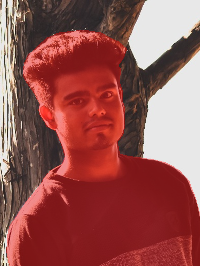

Dataloader parameters:
{'batch_size': 8, 'num_workers': 2, 'shuffle': True, 'drop_last': True}
Dataset parameters
{'root_dir': '/content/data/supervisely-persons', 'list_file': 'train.csv', 'cache_labels': False, 'cache_images': False, 'transforms': [{'SegRandomRescale': {'scales': [0.25, 1.0]}}, {'SegColorJitter': {'brightness': 0.5, 'contrast': 0.5, 'saturation': 0.5}}, {'SegRandomFlip': {'prob': 0.5}}, {'SegPadShortToCropSize': {'crop_size': [320, 480], 'fill_mask': 0}}, {'SegCropImageAndMask': {'crop_size': [320, 480], 'mode': 'random'}}]}


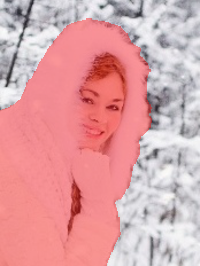

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


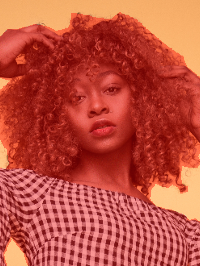

In [6]:
from PIL import Image
from torchvision.utils import draw_segmentation_masks
from torchvision.transforms import ToTensor, ToPILImage, Resize
import numpy as np
import torch

def plot_seg_data(img_path: str, target_path: str):
  image = (ToTensor()(Image.open(img_path).convert('RGB')) * 255).type(torch.uint8)
  target = torch.from_numpy(np.array(Image.open(target_path))).bool()
  image = draw_segmentation_masks(image, target, colors="red", alpha=0.4)
  image = Resize(size=200)(image)
  display(ToPILImage()(image))

for i in range(4, 7):
  img_path, target_path = train_loader.dataset.samples_targets_tuples_list[i]
  plot_seg_data(img_path, target_path)

# 3. Architecture definition



SG includes implementations of many different architectures for semantic segmentation tasks that can be found [here](https://github.com/Deci-AI/super-gradients#implemented-model-architectures).

Create a PPLiteSeg nn.Module, with 1 class segmentation head classifier. For simplicity `use_aux_head` is set as `False`
and extra Auxiliary heads aren't used for training.

Other segmentation modules can be used for this task such as, DDRNet, STDC and RegSeg.


In [7]:
from super_gradients.training import models
from super_gradients.common.object_names import Models

model = models.get(model_name=Models.PP_LITE_T_SEG75,
                   arch_params={"use_aux_heads": False},
                   num_classes=1,
                   pretrained_weights="cityscapes")

Downloading: "https://sghub.deci.ai/models/pp_lite_t_seg75_cityscapes.pth" to /root/.cache/torch/hub/checkpoints/pp_lite_t_seg75_cityscapes.pth
100%|██████████| 31.4M/31.4M [00:01<00:00, 26.4MB/s]
[2023-11-13 12:19:38] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture pp_lite_t_seg75


# 4. Training setup





Here we define the training recipe. The full parameters can be found here  [training parameters supported](https://deci-ai.github.io/super-gradients/user_guide.html#training-parameters).

We will be using an average of BCE and Dice loss for segmentation, with different learning rates for the replaced segmentation head layer, and the rest of the network- this is controlled by the `multiply_head_lr` parameter which is the multiplication factor of the learning rate for the newly replaced layer.

As our `metric_to_watch`, we will be monitoring the `target_IOU` which is one of the components of `BinaryIOU` torchmetrics object (the other components are `mean_IOU` which is the mean of the background and target IOUs, and `background_IOU`).

In [8]:
from super_gradients.training.metrics.segmentation_metrics import BinaryIOU
from super_gradients.training.utils.callbacks import BinarySegmentationVisualizationCallback, Phase

train_params = {"max_epochs": 15,
                "lr_mode": "cosine",
                "initial_lr": 0.005,
                "lr_warmup_epochs": 5,
                "multiply_head_lr": 10,
                "optimizer": "SGD",
                "loss": "BCEDiceLoss",
                "ema": True,
                "ema_params":
                {
                "decay": 0.9999,
                "decay_type": "exp",
                "beta": 15,
                },
                "zero_weight_decay_on_bias_and_bn": True,
                "average_best_models": True,
                "metric_to_watch": "target_IOU",
                "greater_metric_to_watch_is_better": True,
                "train_metrics_list": [BinaryIOU()],
                "valid_metrics_list": [BinaryIOU()],
                "loss_logging_items_names": ["loss"],
                "phase_callbacks": [BinarySegmentationVisualizationCallback(phase=Phase.VALIDATION_BATCH_END,
                                                                            freq=1,
                                                                            last_img_idx_in_batch=4)],
                }

# 5. Training and evaluation


The logs and the checkpoint for the latest epoch will be kept in your experiment folder.

To start training we'll call train(...) and provide it with the objects we construted above: the model, the training parameters and the data loaders.

**Note:** While training, don't forget to refresh the tensorboard with the arrow on the top right.

In [9]:
trainer.train(model=model, training_params=train_params, train_loader=train_loader, valid_loader=valid_loader)

[2023-11-13 12:19:47] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231113_121947_461500`
[2023-11-13 12:19:47] INFO - sg_trainer.py - Checkpoints directory: ./notebook_ckpts/segmentation_transfer_learning/RUN_20231113_121947_461500
[2023-11-13 12:19:47] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9999, 'decay_type': 'exp', 'beta': 15}


The console stream is now moved to ./notebook_ckpts/segmentation_transfer_learning/RUN_20231113_121947_461500/console_Nov13_12_19_47.txt


[2023-11-13 12:19:49] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            2477       (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_size)
    - Effective Batch size:         8          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         309        (len(train_loader))
    - Gradient updates per epoch:   309        (len(train_loader) / batch_accumulate)

[2023-11-13 12:19:49] INFO - sg_trainer.py - Started training for 15 epochs (0/14)

Validating: 100%|██████████| 65/65 [00:16<00:00,  4.02it/s]
[2023-11-13 12:22:01] INFO - base_sg_logger.py - Checkpoint saved in ./notebook_ckpts/segmentation_transfer_learning/RUN_20231113_121947_461500/ckpt_best.pt

SUMMARY OF EPOCH 0
├── Train
│   ├── Bcediceloss = 0.2242
│   ├── Target_iou = 0.8072
│   ├── Background_iou = 0.7463
│   └── Mean_iou = 0.7768
└── Validation
    ├── Bcediceloss = 0.1872
    ├── Target_iou = 0.8527
    ├── Background_iou = 0.7289
    └── Mean_iou = 0.7908



Validating epoch 1: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]
[2023-11-13 12:24:04] INFO - base_sg_logger.py - Checkpoint saved in ./notebook_ckpts/segmentation_transfer_learning/RUN_20231113_121947_461500/ckpt_best.pth
[2023-11-13 12:24:04] INFO - sg_trainer.py - Best checkpoint overriden: validation target_IOU: 0.8766682147979736


SUMMARY OF EPOCH 1
├── Train
│   ├── Bcediceloss = 0.167
│   │   ├── Epoch N-1      = 0.2242 (↘ -0.0572)
│   │   └── Best until now = 0.2242 (↘ -0.0572)
│   ├── Target_iou = 0.8588
│   │   ├── Epoch N-1      = 0.8072 (↗ 0.0516)
│   │   └── Best until now = 0.8072 (↗ 0.0516)
│   ├── Background_iou = 0.8137
│   │   ├── Epoch N-1      = 0.7463 (↗ 0.0673)
│   │   └── Best until now = 0.7463 (↗ 0.0673)
│   └── Mean_iou = 0.8362
│       ├── Epoch N-1      = 0.7768 (↗ 0.0594)
│       └── Best until now = 0.7768 (↗ 0.0594)
└── Validation
    ├── Bcediceloss = 0.155
    │   ├── Epoch N-1      = 0.1872 (↘ -0.0321)
    │   └── Best until now = 0.1872 (↘ -0.0321)
    ├── Target_iou = 0.8767
    │   ├── Epoch N-1      = 0.8527 (↗ 0.0239)
    │   └── Best until now = 0.8527 (↗ 0.0239)
    ├── Background_iou = 0.7812
    │   ├── Epoch N-1      = 0.7289 (↗ 0.0522)
    │   └── Best until now = 0.7289 (↗ 0.0522)
    └── Mean_iou = 0.8289
        ├── Epoch N-1      = 0.7908 (↗ 0.0381)
        └── Best un

Validating epoch 2: 100%|██████████| 65/65 [00:14<00:00,  4.37it/s]
[2023-11-13 12:26:05] INFO - base_sg_logger.py - Checkpoint saved in ./notebook_ckpts/segmentation_transfer_learning/RUN_20231113_121947_461500/ckpt_best.pth
[2023-11-13 12:26:05] INFO - sg_trainer.py - Best checkpoint overriden: validation target_IOU: 0.8859243988990784


SUMMARY OF EPOCH 2
├── Train
│   ├── Bcediceloss = 0.1456
│   │   ├── Epoch N-1      = 0.167  (↘ -0.0213)
│   │   └── Best until now = 0.167  (↘ -0.0213)
│   ├── Target_iou = 0.8769
│   │   ├── Epoch N-1      = 0.8588 (↗ 0.0181)
│   │   └── Best until now = 0.8588 (↗ 0.0181)
│   ├── Background_iou = 0.8434
│   │   ├── Epoch N-1      = 0.8137 (↗ 0.0297)
│   │   └── Best until now = 0.8137 (↗ 0.0297)
│   └── Mean_iou = 0.8601
│       ├── Epoch N-1      = 0.8362 (↗ 0.0239)
│       └── Best until now = 0.8362 (↗ 0.0239)
└── Validation
    ├── Bcediceloss = 0.145
    │   ├── Epoch N-1      = 0.155  (↘ -0.01)
    │   └── Best until now = 0.155  (↘ -0.01)
    ├── Target_iou = 0.8859
    │   ├── Epoch N-1      = 0.8767 (↗ 0.0093)
    │   └── Best until now = 0.8767 (↗ 0.0093)
    ├── Background_iou = 0.7947
    │   ├── Epoch N-1      = 0.7812 (↗ 0.0135)
    │   └── Best until now = 0.7812 (↗ 0.0135)
    └── Mean_iou = 0.8403
        ├── Epoch N-1      = 0.8289 (↗ 0.0114)
        └── Best until

Validating epoch 3: 100%|██████████| 65/65 [00:16<00:00,  3.93it/s]
[2023-11-13 12:28:07] INFO - base_sg_logger.py - Checkpoint saved in ./notebook_ckpts/segmentation_transfer_learning/RUN_20231113_121947_461500/ckpt_best.pth
[2023-11-13 12:28:07] INFO - sg_trainer.py - Best checkpoint overriden: validation target_IOU: 0.9014593362808228


SUMMARY OF EPOCH 3
├── Train
│   ├── Bcediceloss = 0.1318
│   │   ├── Epoch N-1      = 0.1456 (↘ -0.0138)
│   │   └── Best until now = 0.1456 (↘ -0.0138)
│   ├── Target_iou = 0.8852
│   │   ├── Epoch N-1      = 0.8769 (↗ 0.0083)
│   │   └── Best until now = 0.8769 (↗ 0.0083)
│   ├── Background_iou = 0.8559
│   │   ├── Epoch N-1      = 0.8434 (↗ 0.0125)
│   │   └── Best until now = 0.8434 (↗ 0.0125)
│   └── Mean_iou = 0.8706
│       ├── Epoch N-1      = 0.8601 (↗ 0.0104)
│       └── Best until now = 0.8601 (↗ 0.0104)
└── Validation
    ├── Bcediceloss = 0.1255
    │   ├── Epoch N-1      = 0.145  (↘ -0.0195)
    │   └── Best until now = 0.145  (↘ -0.0195)
    ├── Target_iou = 0.9015
    │   ├── Epoch N-1      = 0.8859 (↗ 0.0155)
    │   └── Best until now = 0.8859 (↗ 0.0155)
    ├── Background_iou = 0.8281
    │   ├── Epoch N-1      = 0.7947 (↗ 0.0334)
    │   └── Best until now = 0.7947 (↗ 0.0334)
    └── Mean_iou = 0.8648
        ├── Epoch N-1      = 0.8403 (↗ 0.0245)
        └── Best 

Validating epoch 4: 100%|██████████| 65/65 [00:16<00:00,  3.94it/s]
[2023-11-13 12:30:07] INFO - base_sg_logger.py - Checkpoint saved in ./notebook_ckpts/segmentation_transfer_learning/RUN_20231113_121947_461500/ckpt_best.pth
[2023-11-13 12:30:07] INFO - sg_trainer.py - Best checkpoint overriden: validation target_IOU: 0.9075297117233276


SUMMARY OF EPOCH 4
├── Train
│   ├── Bcediceloss = 0.1216
│   │   ├── Epoch N-1      = 0.1318 (↘ -0.0102)
│   │   └── Best until now = 0.1318 (↘ -0.0102)
│   ├── Target_iou = 0.8963
│   │   ├── Epoch N-1      = 0.8852 (↗ 0.0111)
│   │   └── Best until now = 0.8852 (↗ 0.0111)
│   ├── Background_iou = 0.8663
│   │   ├── Epoch N-1      = 0.8559 (↗ 0.0104)
│   │   └── Best until now = 0.8559 (↗ 0.0104)
│   └── Mean_iou = 0.8813
│       ├── Epoch N-1      = 0.8706 (↗ 0.0107)
│       └── Best until now = 0.8706 (↗ 0.0107)
└── Validation
    ├── Bcediceloss = 0.1177
    │   ├── Epoch N-1      = 0.1255 (↘ -0.0078)
    │   └── Best until now = 0.1255 (↘ -0.0078)
    ├── Target_iou = 0.9075
    │   ├── Epoch N-1      = 0.9015 (↗ 0.0061)
    │   └── Best until now = 0.9015 (↗ 0.0061)
    ├── Background_iou = 0.8385
    │   ├── Epoch N-1      = 0.8281 (↗ 0.0103)
    │   └── Best until now = 0.8281 (↗ 0.0103)
    └── Mean_iou = 0.873
        ├── Epoch N-1      = 0.8648 (↗ 0.0082)
        └── Best u

Validating epoch 5: 100%|██████████| 65/65 [00:14<00:00,  4.47it/s]


SUMMARY OF EPOCH 5
├── Train
│   ├── Bcediceloss = 0.1214
│   │   ├── Epoch N-1      = 0.1216 (↘ -0.0002)
│   │   └── Best until now = 0.1216 (↘ -0.0002)
│   ├── Target_iou = 0.8954
│   │   ├── Epoch N-1      = 0.8963 (↘ -0.0009)
│   │   └── Best until now = 0.8963 (↘ -0.0009)
│   ├── Background_iou = 0.8655
│   │   ├── Epoch N-1      = 0.8663 (↘ -0.0008)
│   │   └── Best until now = 0.8663 (↘ -0.0008)
│   └── Mean_iou = 0.8804
│       ├── Epoch N-1      = 0.8813 (↘ -0.0008)
│       └── Best until now = 0.8813 (↘ -0.0008)
└── Validation
    ├── Bcediceloss = 0.1194
    │   ├── Epoch N-1      = 0.1177 (↗ 0.0017)
    │   └── Best until now = 0.1177 (↗ 0.0017)
    ├── Target_iou = 0.9054
    │   ├── Epoch N-1      = 0.9075 (↘ -0.0021)
    │   └── Best until now = 0.9075 (↘ -0.0021)
    ├── Background_iou = 0.8344
    │   ├── Epoch N-1      = 0.8385 (↘ -0.004)
    │   └── Best until now = 0.8385 (↘ -0.004)
    └── Mean_iou = 0.8699
        ├── Epoch N-1      = 0.873  (↘ -0.0031)
        └─

Validating epoch 6: 100%|██████████| 65/65 [00:16<00:00,  3.90it/s]


SUMMARY OF EPOCH 6
├── Train
│   ├── Bcediceloss = 0.1177
│   │   ├── Epoch N-1      = 0.1214 (↘ -0.0037)
│   │   └── Best until now = 0.1214 (↘ -0.0037)
│   ├── Target_iou = 0.8986
│   │   ├── Epoch N-1      = 0.8954 (↗ 0.0032)
│   │   └── Best until now = 0.8963 (↗ 0.0023)
│   ├── Background_iou = 0.8702
│   │   ├── Epoch N-1      = 0.8655 (↗ 0.0047)
│   │   └── Best until now = 0.8663 (↗ 0.0039)
│   └── Mean_iou = 0.8844
│       ├── Epoch N-1      = 0.8804 (↗ 0.004)
│       └── Best until now = 0.8813 (↗ 0.0031)
└── Validation
    ├── Bcediceloss = 0.117
    │   ├── Epoch N-1      = 0.1194 (↘ -0.0024)
    │   └── Best until now = 0.1177 (↘ -0.0007)
    ├── Target_iou = 0.9073
    │   ├── Epoch N-1      = 0.9054 (↗ 0.0019)
    │   └── Best until now = 0.9075 (↘ -0.0003)
    ├── Background_iou = 0.8375
    │   ├── Epoch N-1      = 0.8344 (↗ 0.0031)
    │   └── Best until now = 0.8385 (↘ -0.001)
    └── Mean_iou = 0.8724
        ├── Epoch N-1      = 0.8699 (↗ 0.0025)
        └── Best u

Validating epoch 7: 100%|██████████| 65/65 [00:15<00:00,  4.10it/s]
[2023-11-13 12:36:14] INFO - base_sg_logger.py - Checkpoint saved in ./notebook_ckpts/segmentation_transfer_learning/RUN_20231113_121947_461500/ckpt_best.pth
[2023-11-13 12:36:14] INFO - sg_trainer.py - Best checkpoint overriden: validation target_IOU: 0.9087882041931152


SUMMARY OF EPOCH 7
├── Train
│   ├── Bcediceloss = 0.1099
│   │   ├── Epoch N-1      = 0.1177 (↘ -0.0078)
│   │   └── Best until now = 0.1177 (↘ -0.0078)
│   ├── Target_iou = 0.9051
│   │   ├── Epoch N-1      = 0.8986 (↗ 0.0064)
│   │   └── Best until now = 0.8986 (↗ 0.0064)
│   ├── Background_iou = 0.8775
│   │   ├── Epoch N-1      = 0.8702 (↗ 0.0073)
│   │   └── Best until now = 0.8702 (↗ 0.0073)
│   └── Mean_iou = 0.8913
│       ├── Epoch N-1      = 0.8844 (↗ 0.0069)
│       └── Best until now = 0.8844 (↗ 0.0069)
└── Validation
    ├── Bcediceloss = 0.1151
    │   ├── Epoch N-1      = 0.117  (↘ -0.002)
    │   └── Best until now = 0.117  (↘ -0.002)
    ├── Target_iou = 0.9088
    │   ├── Epoch N-1      = 0.9073 (↗ 0.0015)
    │   └── Best until now = 0.9075 (↗ 0.0013)
    ├── Background_iou = 0.8402
    │   ├── Epoch N-1      = 0.8375 (↗ 0.0027)
    │   └── Best until now = 0.8385 (↗ 0.0017)
    └── Mean_iou = 0.8745
        ├── Epoch N-1      = 0.8724 (↗ 0.0021)
        └── Best un

Validating epoch 8: 100%|██████████| 65/65 [00:16<00:00,  3.94it/s]
[2023-11-13 12:38:18] INFO - base_sg_logger.py - Checkpoint saved in ./notebook_ckpts/segmentation_transfer_learning/RUN_20231113_121947_461500/ckpt_best.pth
[2023-11-13 12:38:18] INFO - sg_trainer.py - Best checkpoint overriden: validation target_IOU: 0.9094919562339783


SUMMARY OF EPOCH 8
├── Train
│   ├── Bcediceloss = 0.0972
│   │   ├── Epoch N-1      = 0.1099 (↘ -0.0127)
│   │   └── Best until now = 0.1099 (↘ -0.0127)
│   ├── Target_iou = 0.9145
│   │   ├── Epoch N-1      = 0.9051 (↗ 0.0095)
│   │   └── Best until now = 0.9051 (↗ 0.0095)
│   ├── Background_iou = 0.8892
│   │   ├── Epoch N-1      = 0.8775 (↗ 0.0117)
│   │   └── Best until now = 0.8775 (↗ 0.0117)
│   └── Mean_iou = 0.9019
│       ├── Epoch N-1      = 0.8913 (↗ 0.0106)
│       └── Best until now = 0.8913 (↗ 0.0106)
└── Validation
    ├── Bcediceloss = 0.1142
    │   ├── Epoch N-1      = 0.1151 (↘ -0.0008)
    │   └── Best until now = 0.1151 (↘ -0.0008)
    ├── Target_iou = 0.9095
    │   ├── Epoch N-1      = 0.9088 (↗ 0.0007)
    │   └── Best until now = 0.9088 (↗ 0.0007)
    ├── Background_iou = 0.8414
    │   ├── Epoch N-1      = 0.8402 (↗ 0.0013)
    │   └── Best until now = 0.8402 (↗ 0.0013)
    └── Mean_iou = 0.8755
        ├── Epoch N-1      = 0.8745 (↗ 0.001)
        └── Best u

Validating epoch 9: 100%|██████████| 65/65 [00:15<00:00,  4.28it/s]
[2023-11-13 12:40:20] INFO - base_sg_logger.py - Checkpoint saved in ./notebook_ckpts/segmentation_transfer_learning/RUN_20231113_121947_461500/ckpt_best.pth
[2023-11-13 12:40:20] INFO - sg_trainer.py - Best checkpoint overriden: validation target_IOU: 0.9101359248161316


SUMMARY OF EPOCH 9
├── Train
│   ├── Bcediceloss = 0.0938
│   │   ├── Epoch N-1      = 0.0972 (↘ -0.0034)
│   │   └── Best until now = 0.0972 (↘ -0.0034)
│   ├── Target_iou = 0.9184
│   │   ├── Epoch N-1      = 0.9145 (↗ 0.0039)
│   │   └── Best until now = 0.9145 (↗ 0.0039)
│   ├── Background_iou = 0.8955
│   │   ├── Epoch N-1      = 0.8892 (↗ 0.0063)
│   │   └── Best until now = 0.8892 (↗ 0.0063)
│   └── Mean_iou = 0.907
│       ├── Epoch N-1      = 0.9019 (↗ 0.0051)
│       └── Best until now = 0.9019 (↗ 0.0051)
└── Validation
    ├── Bcediceloss = 0.1134
    │   ├── Epoch N-1      = 0.1142 (↘ -0.0008)
    │   └── Best until now = 0.1142 (↘ -0.0008)
    ├── Target_iou = 0.9101
    │   ├── Epoch N-1      = 0.9095 (↗ 0.0006)
    │   └── Best until now = 0.9095 (↗ 0.0006)
    ├── Background_iou = 0.8427
    │   ├── Epoch N-1      = 0.8414 (↗ 0.0012)
    │   └── Best until now = 0.8414 (↗ 0.0012)
    └── Mean_iou = 0.8764
        ├── Epoch N-1      = 0.8755 (↗ 0.0009)
        └── Best u

Validating epoch 10: 100%|██████████| 65/65 [00:16<00:00,  3.89it/s]
[2023-11-13 12:42:25] INFO - base_sg_logger.py - Checkpoint saved in ./notebook_ckpts/segmentation_transfer_learning/RUN_20231113_121947_461500/ckpt_best.pth
[2023-11-13 12:42:25] INFO - sg_trainer.py - Best checkpoint overriden: validation target_IOU: 0.9106564521789551


SUMMARY OF EPOCH 10
├── Train
│   ├── Bcediceloss = 0.0853
│   │   ├── Epoch N-1      = 0.0938 (↘ -0.0085)
│   │   └── Best until now = 0.0938 (↘ -0.0085)
│   ├── Target_iou = 0.9241
│   │   ├── Epoch N-1      = 0.9184 (↗ 0.0057)
│   │   └── Best until now = 0.9184 (↗ 0.0057)
│   ├── Background_iou = 0.9023
│   │   ├── Epoch N-1      = 0.8955 (↗ 0.0068)
│   │   └── Best until now = 0.8955 (↗ 0.0068)
│   └── Mean_iou = 0.9132
│       ├── Epoch N-1      = 0.907  (↗ 0.0062)
│       └── Best until now = 0.907  (↗ 0.0062)
└── Validation
    ├── Bcediceloss = 0.1127
    │   ├── Epoch N-1      = 0.1134 (↘ -0.0007)
    │   └── Best until now = 0.1134 (↘ -0.0007)
    ├── Target_iou = 0.9107
    │   ├── Epoch N-1      = 0.9101 (↗ 0.0005)
    │   └── Best until now = 0.9101 (↗ 0.0005)
    ├── Background_iou = 0.8437
    │   ├── Epoch N-1      = 0.8427 (↗ 0.001)
    │   └── Best until now = 0.8427 (↗ 0.001)
    └── Mean_iou = 0.8772
        ├── Epoch N-1      = 0.8764 (↗ 0.0008)
        └── Best u

Validating epoch 11: 100%|██████████| 65/65 [00:15<00:00,  4.13it/s]
[2023-11-13 12:44:34] INFO - base_sg_logger.py - Checkpoint saved in ./notebook_ckpts/segmentation_transfer_learning/RUN_20231113_121947_461500/ckpt_best.pth
[2023-11-13 12:44:34] INFO - sg_trainer.py - Best checkpoint overriden: validation target_IOU: 0.9110515117645264


SUMMARY OF EPOCH 11
├── Train
│   ├── Bcediceloss = 0.0808
│   │   ├── Epoch N-1      = 0.0853 (↘ -0.0046)
│   │   └── Best until now = 0.0853 (↘ -0.0046)
│   ├── Target_iou = 0.9301
│   │   ├── Epoch N-1      = 0.9241 (↗ 0.006)
│   │   └── Best until now = 0.9241 (↗ 0.006)
│   ├── Background_iou = 0.9075
│   │   ├── Epoch N-1      = 0.9023 (↗ 0.0053)
│   │   └── Best until now = 0.9023 (↗ 0.0053)
│   └── Mean_iou = 0.9188
│       ├── Epoch N-1      = 0.9132 (↗ 0.0056)
│       └── Best until now = 0.9132 (↗ 0.0056)
└── Validation
    ├── Bcediceloss = 0.1121
    │   ├── Epoch N-1      = 0.1127 (↘ -0.0006)
    │   └── Best until now = 0.1127 (↘ -0.0006)
    ├── Target_iou = 0.9111
    │   ├── Epoch N-1      = 0.9107 (↗ 0.0004)
    │   └── Best until now = 0.9107 (↗ 0.0004)
    ├── Background_iou = 0.8445
    │   ├── Epoch N-1      = 0.8437 (↗ 0.0008)
    │   └── Best until now = 0.8437 (↗ 0.0008)
    └── Mean_iou = 0.8778
        ├── Epoch N-1      = 0.8772 (↗ 0.0006)
        └── Best u

Validating epoch 12: 100%|██████████| 65/65 [00:16<00:00,  3.92it/s]
[2023-11-13 12:46:40] INFO - base_sg_logger.py - Checkpoint saved in ./notebook_ckpts/segmentation_transfer_learning/RUN_20231113_121947_461500/ckpt_best.pth
[2023-11-13 12:46:40] INFO - sg_trainer.py - Best checkpoint overriden: validation target_IOU: 0.9114375114440918


SUMMARY OF EPOCH 12
├── Train
│   ├── Bcediceloss = 0.0779
│   │   ├── Epoch N-1      = 0.0808 (↘ -0.0029)
│   │   └── Best until now = 0.0808 (↘ -0.0029)
│   ├── Target_iou = 0.9317
│   │   ├── Epoch N-1      = 0.9301 (↗ 0.0016)
│   │   └── Best until now = 0.9301 (↗ 0.0016)
│   ├── Background_iou = 0.9113
│   │   ├── Epoch N-1      = 0.9075 (↗ 0.0038)
│   │   └── Best until now = 0.9075 (↗ 0.0038)
│   └── Mean_iou = 0.9215
│       ├── Epoch N-1      = 0.9188 (↗ 0.0027)
│       └── Best until now = 0.9188 (↗ 0.0027)
└── Validation
    ├── Bcediceloss = 0.1115
    │   ├── Epoch N-1      = 0.1121 (↘ -0.0006)
    │   └── Best until now = 0.1121 (↘ -0.0006)
    ├── Target_iou = 0.9114
    │   ├── Epoch N-1      = 0.9111 (↗ 0.0004)
    │   └── Best until now = 0.9111 (↗ 0.0004)
    ├── Background_iou = 0.8453
    │   ├── Epoch N-1      = 0.8445 (↗ 0.0008)
    │   └── Best until now = 0.8445 (↗ 0.0008)
    └── Mean_iou = 0.8784
        ├── Epoch N-1      = 0.8778 (↗ 0.0006)
        └── Best

Validating epoch 13: 100%|██████████| 65/65 [00:16<00:00,  3.97it/s]
[2023-11-13 12:48:53] INFO - base_sg_logger.py - Checkpoint saved in ./notebook_ckpts/segmentation_transfer_learning/RUN_20231113_121947_461500/ckpt_best.pth
[2023-11-13 12:48:53] INFO - sg_trainer.py - Best checkpoint overriden: validation target_IOU: 0.9118204712867737


SUMMARY OF EPOCH 13
├── Train
│   ├── Bcediceloss = 0.0748
│   │   ├── Epoch N-1      = 0.0779 (↘ -0.0031)
│   │   └── Best until now = 0.0779 (↘ -0.0031)
│   ├── Target_iou = 0.9349
│   │   ├── Epoch N-1      = 0.9317 (↗ 0.0032)
│   │   └── Best until now = 0.9317 (↗ 0.0032)
│   ├── Background_iou = 0.9165
│   │   ├── Epoch N-1      = 0.9113 (↗ 0.0052)
│   │   └── Best until now = 0.9113 (↗ 0.0052)
│   └── Mean_iou = 0.9257
│       ├── Epoch N-1      = 0.9215 (↗ 0.0042)
│       └── Best until now = 0.9215 (↗ 0.0042)
└── Validation
    ├── Bcediceloss = 0.111
    │   ├── Epoch N-1      = 0.1115 (↘ -0.0006)
    │   └── Best until now = 0.1115 (↘ -0.0006)
    ├── Target_iou = 0.9118
    │   ├── Epoch N-1      = 0.9114 (↗ 0.0004)
    │   └── Best until now = 0.9114 (↗ 0.0004)
    ├── Background_iou = 0.8461
    │   ├── Epoch N-1      = 0.8453 (↗ 0.0008)
    │   └── Best until now = 0.8453 (↗ 0.0008)
    └── Mean_iou = 0.879
        ├── Epoch N-1      = 0.8784 (↗ 0.0006)
        └── Best u

Validating epoch 14: 100%|██████████| 65/65 [00:16<00:00,  3.89it/s]
[2023-11-13 12:51:00] INFO - base_sg_logger.py - Checkpoint saved in ./notebook_ckpts/segmentation_transfer_learning/RUN_20231113_121947_461500/ckpt_best.pth
[2023-11-13 12:51:00] INFO - sg_trainer.py - Best checkpoint overriden: validation target_IOU: 0.9122186303138733


SUMMARY OF EPOCH 14
├── Train
│   ├── Bcediceloss = 0.0742
│   │   ├── Epoch N-1      = 0.0748 (↘ -0.0006)
│   │   └── Best until now = 0.0748 (↘ -0.0006)
│   ├── Target_iou = 0.9343
│   │   ├── Epoch N-1      = 0.9349 (↘ -0.0006)
│   │   └── Best until now = 0.9349 (↘ -0.0006)
│   ├── Background_iou = 0.9147
│   │   ├── Epoch N-1      = 0.9165 (↘ -0.0017)
│   │   └── Best until now = 0.9165 (↘ -0.0017)
│   └── Mean_iou = 0.9245
│       ├── Epoch N-1      = 0.9257 (↘ -0.0012)
│       └── Best until now = 0.9257 (↘ -0.0012)
└── Validation
    ├── Bcediceloss = 0.1104
    │   ├── Epoch N-1      = 0.111  (↘ -0.0005)
    │   └── Best until now = 0.111  (↘ -0.0005)
    ├── Target_iou = 0.9122
    │   ├── Epoch N-1      = 0.9118 (↗ 0.0004)
    │   └── Best until now = 0.9118 (↗ 0.0004)
    ├── Background_iou = 0.8469
    │   ├── Epoch N-1      = 0.8461 (↗ 0.0008)
    │   └── Best until now = 0.8461 (↗ 0.0008)
    └── Mean_iou = 0.8796
        ├── Epoch N-1      = 0.879  (↗ 0.0006)
        └─

[2023-11-13 12:51:04] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 15:  97%|█████████▋| 63/65 [00:17<00:00,  5.89it/s]

In [10]:
print("Best Checkpoint mIoU is: "+ str(trainer.best_metric))

Now you can download your trained weights from this directory

In [11]:
print(trainer.checkpoints_dir_path)

# 6. Predict


When the training is complete you can use the trained model to get predictions on the validation set, your data or some other image. Let's load some image and
run a model inference to create a binary segmentation mask.

Validating epoch 15: 100%|██████████| 65/65 [00:18<00:00,  3.56it/s]
[2023-11-13 12:51:23] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


Best Checkpoint mIoU is: 0.9122186303138733
./notebook_ckpts/segmentation_transfer_learning/RUN_20231113_121947_461500


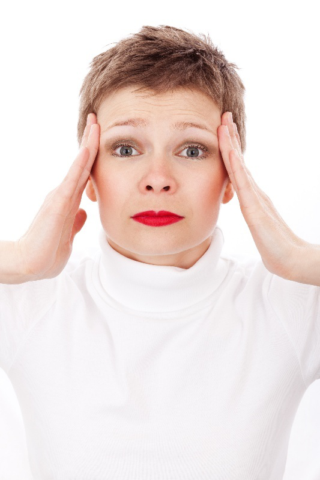

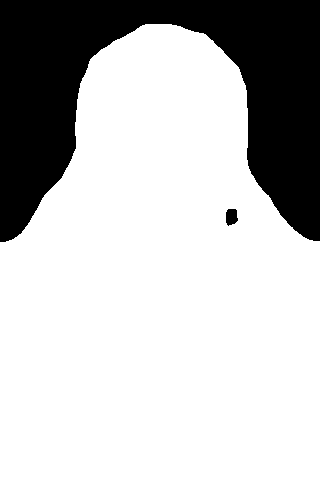

In [12]:
from torchvision.transforms import Compose, ToTensor, Resize, Normalize, ToPILImage

# Initiate a model with best checkpoint.
model = models.get(model_name=Models.PP_LITE_T_SEG75,
                   arch_params={"use_aux_heads": False},
                   num_classes=1,
                   checkpoint_path=os.path.join(trainer.checkpoints_dir_path, "ckpt_best.pth")).cuda().eval()

pre_proccess = Compose([
    ToTensor(),
    Normalize([.485, .456, .406], [.229, .224, .225])
])

demo_img_path = os.path.join(root_dir, "images", "ache-adult-depression-expression-41253.png")

img = Image.open(demo_img_path)
# Resize the image and display
img = Resize(size=(480, 320))(img)
display(img)

# Run pre-proccess - transforms to tensor and apply normalizations.
img_inp = pre_proccess(img).unsqueeze(0).cuda()

# Run inference
mask = model(img_inp)

# Run post-proccess - apply sigmoid to output probabilities, then apply hard
# threshold of 0.5 for binary mask prediction.
mask = torch.sigmoid(mask).gt(0.5).squeeze()
mask = ToPILImage()(mask.float())
display(mask)


# 7. Convert to ONNX/TensorRT

Let's compile our model to ONNX.

In [14]:
from onnxsim import simplify
import onnx

onnx_path = os.path.join(os.getcwd(), "model.onnx")

input_size = [1, 3, 480, 320]
model.prep_model_for_conversion(input_size=input_size)

torch.onnx.export(model,
                  torch.randn(*input_size).cuda(),
                  onnx_path)

# onnx simplifier
model_sim, check = simplify(onnx_path)
assert check, "Simplified ONNX model could not be validated"
onnx.save_model(model_sim, onnx_path)

print("ONNX successfully created at: ", onnx_path)


ONNX successfully created at:  /content/data/model.onnx
